In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features

import os
from collections import defaultdict
import json
import pg8000
import h5py

In [3]:
h5_path = '\\\\titan\\cns\\mousecelltypes\\prod882\\Ephys_Roi_Result_567235960\\Chrna2-Cre_OE25;Ai14(IVSCC)-294916.04.01.01.h5' 

In [4]:
df_2016 = pd.read_pickle('df_2016.pkl')

In [5]:
###code from Agata
###modified

key_path = "MIES/LabNoteBook/ITC18USB/Device0/TextDocKeyWave"
data_path = "MIES/LabNoteBook/ITC18USB/Device0/textDocumentation/txtDocWave"
d_1904 = datetime.strptime("1904-01-01", "%Y-%m-%d")


with h5py.File(h5_path) as f:
    f = h5py.File(h5_path)
    set_keys = f[key_path].get("txtDocKeyWave")[0]
    set_vals = f[data_path]

ts_idx = np.where(set_keys == "TimeStamp")[0][0]
name_idx =  np.where(set_keys == "Stim Wave Name")[0][0]
num_idx = np.where(set_keys == 'Sweep #')[0][0]
sw_names = [set_vals[entry, name_idx, 0] for entry in range(set_vals.shape[0])]
ts_nums = [set_vals[entry, ts_idx, 0] for entry in range(set_vals.shape[0])]
sw_nums = [set_vals[entry, num_idx, 0] for entry in range(set_vals.shape[0])]

times = [];
sweeps = [];
for i, ts in enumerate(ts_nums):
    if ts != '':
        if sw_names[i].startswith("EXTPBREAKN"):
            print ts
            times.append((d_1904 + timedelta(seconds=float(ts))))
for i, ts in enumerate(ts_nums):
    if ts != '':
        if sw_names[i].startswith("C1RP25PR"):
            print ts
            times.append((d_1904 + timedelta(seconds=float(ts))))
            sweeps.append(sw_nums[i])
for i, ts in enumerate(ts_nums):
    if ts != '':
        if sw_names[i].startswith("C1SSCOARSE"):
            print ts
            times.append((d_1904 + timedelta(seconds=float(ts))))
            sweeps.append(sw_nums[i])

IOError: Unable to create file (Unable to open file: name = '\\titan\cns\mousecelltypes\prod882\ephys_roi_result_567235960\chrna2-cre_oe25;ai14(ivscc)-294916.04.01.01.h5', errno = 2, error message = 'no such file or directory', flags = 15, o_flags = 502)

In [198]:
df = pd.read_pickle('json_and_qc.pkl')
with open(df['json_path'][2274], 'r') as f:
    data = json.load(f)
    
#get dictionary of actual sweep numbers
sweep_numbers = {data['specimens'][0]['ephys_sweeps'][i]['sweep_number']:i for i in range(len(data['specimens'][0]['ephys_sweeps']))}

times = times[:5]
sweeps = sweeps[:4]
voltages = []
for i in sweeps:
    shortened = data['specimens'][0]['ephys_sweeps'][sweep_numbers[int(i)]]['pre_vm_mv']
    voltages.append(shortened)
breakin_v = data['specimens'][0]['cell_ephys_features']['long_squares']['v_baseline']

(-0.5, 3)

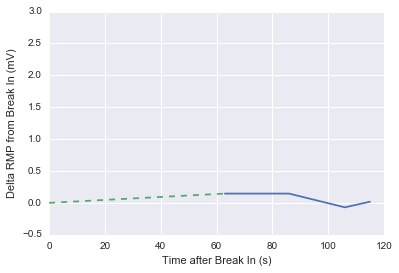

In [63]:
temp_df = df[df['abs_v'] < .4]

plt.plot([(i - temp_df['times'][66][0]).seconds for i in temp_df['times'][66][1:]], [i-temp_df['breakin_v'][66] for i in temp_df['voltages'][66]])
plt.plot([0,(temp_df['times'][66][1]-temp_df['times'][66][0]).seconds],[0,temp_df['voltages'][66][0]-temp_df['breakin_v'][66]],'--')
plt.xlabel('Time after Break In (s)')
plt.ylabel('Delta RMP from Break In (mV)')
plt.ylim(-.5,3)

In [61]:
temp_df

,level_0,index,ACSF Date,Approach Time,BFI Witness,Bad Sweeps,Cre Status,Date,End/Abort Time,Extra Notes,...,h5_path,times,sweeps,voltages,breakin_v,ramps,wait,settle,change,abs_v
66,69,218,170203,14:13:57,LK,"42, 44, 46, 59, 63, 67, 68, 74",Cre+,170206,14:35:55,NaN,...,\\titan\cns\mousecelltypes\prod910\Ephys_Roi_R...,"[2017-02-06 14:15:05, 2017-02-06 14:16:08, 201...","[8, 8, 9, 10]","[-69.162727356, -69.162727356, -69.3785476685,...",-69.308357,pause,63,0.14563,0,0.304352


In [30]:
plt.plot([(i - times[0]).seconds for i in times[1:]], [i-breakin_v for i in voltages])
plt.plot([0,(times[1]-times[0]).seconds],[0,voltages[0]-breakin_v],'--')
plt.xlabel('Time after Break In (s)')
plt.ylabel('Delta RMP from Break In (mV)')

NameError: name 'times' is not defined

In [5]:
def get_json(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%ephys_features.json'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],SplitLinux[5],''))

def get_h5(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%.h5'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find h5 file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    
def get_nwb(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%.nwb'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()

In [3]:
def get_times_and_voltages(json_path, h5_path):
    key_path = "MIES/LabNoteBook/ITC18USB/Device0/TextDocKeyWave"
    data_path = "MIES/LabNoteBook/ITC18USB/Device0/textDocumentation/txtDocWave"
    d_1904 = datetime.strptime("1904-01-01", "%Y-%m-%d")


    with h5py.File(h5_path) as f:
        f = h5py.File(h5_path)
        set_keys = f[key_path].get("txtDocKeyWave")[0]
        set_vals = f[data_path]

    ts_idx = np.where(set_keys == "TimeStamp")[0][0]
    name_idx =  np.where(set_keys == "Stim Wave Name")[0][0]
    num_idx = np.where(set_keys == 'Sweep #')[0][0]
    sw_names = [set_vals[entry, name_idx, 0] for entry in range(set_vals.shape[0])]
    ts_nums = [set_vals[entry, ts_idx, 0] for entry in range(set_vals.shape[0])]
    sw_nums = [set_vals[entry, num_idx, 0] for entry in range(set_vals.shape[0])]

    times = [];
    sweeps = [];
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("EXTPBREAKN"):
                #print ts
                times.append((d_1904 + timedelta(seconds=float(ts))))
    max_times = max(times)
    times = [max(times)]
    
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("C1RP25PR"):
                time_stamp = d_1904 + timedelta(seconds = float(ts))
                if time_stamp > max_times:
                    #print ts
                    times.append(time_stamp)
                    sweeps.append(sw_nums[i])
    max_times = max(times)
    for i, ts in enumerate(ts_nums):
        if ts != '':
            if sw_names[i].startswith("C1SSCOARSE"):
                time_stamp = d_1904 + timedelta(seconds = float(ts))
                if time_stamp > max_times:
                    #print ts
                    times.append(time_stamp)
                    sweeps.append(sw_nums[i])


    with open(json_path, 'r') as f:
        data = json.load(f)

    #get dictionary of actual sweep numbers
    sweep_numbers = {data['specimens'][0]['ephys_sweeps'][i]['sweep_number']:i for i in range(len(data['specimens'][0]['ephys_sweeps']))}

    times = times[:5]
    sweeps = sweeps[:4]
    voltages = []
    
    for i in sweeps:
        shortened = data['specimens'][0]['ephys_sweeps'][sweep_numbers[int(i)]]['pre_vm_mv']
        voltages.append(shortened)
    breakin_v = data['specimens'][0]['cell_ephys_features']['long_squares']['v_baseline']
    
    return times, sweeps, breakin_v, voltages

In [417]:
h5_path = df_2016.h5_path[10]
key_path = "MIES/LabNoteBook/ITC18USB/Device0/TextDocKeyWave"
data_path = "MIES/LabNoteBook/ITC18USB/Device0/textDocumentation/txtDocWave"
d_1904 = datetime.strptime("1904-01-01", "%Y-%m-%d")


with h5py.File(h5_path) as f:
    f = h5py.File(h5_path)
    set_keys = f[key_path].get("txtDocKeyWave")[0]
    set_vals = f[data_path]
    

ts_idx = np.where(set_keys == "TimeStamp")[0][0]
name_idx =  np.where(set_keys == "Stim Wave Name")[0][0]
num_idx = np.where(set_keys == 'Sweep #')[0][0]
sw_names = [set_vals[entry, name_idx, 0] for entry in range(set_vals.shape[0])]
ts_nums = [set_vals[entry, ts_idx, 0] for entry in range(set_vals.shape[0])]
sw_nums = [set_vals[entry, num_idx, 0] for entry in range(set_vals.shape[0])]

In [418]:
set_keys

array(['Sweep #', 'TimeStamp', 'TimeStampSinceIgorEpochUTC',
       'OperatingModeString', 'ScaledOutSignalString',
       'ScaleFactorUnitsString', 'RawOutSignalString',
       'RawScaleFactorUnitsString', 'HardwareTypeString', 'Stim Wave Name',
       'DA unit', 'AD unit', 'TTL rack zero stim sets',
       'TTL rack one stim sets', 'Pre DAQ function', 'Mid sweep function',
       'Post sweep function', 'Post set function', 'Post DAQ function',
       'Follower Device', 'MIES version'], dtype=object)

In [18]:
df = pd.read_csv('ramps.csv')
df = df[df['Specimen Name'] != 'no cell'].reset_index()
df['voltages'] = None
for i, specimen in enumerate(df['Specimen Name']):
    df['json_path'][i] = get_json(specimen.split('-')[-1])
    df['h5_path'][i] = get_h5(specimen.split('-')[-1])
    try:
        df['times'][i], df['sweeps'][i], df['breakin_v'][i], df['voltages'][i] = get_times_and_voltages(df['json_path'][i], df['h5_path'][i])
    except TypeError:
        pass
df = df[df['breakin_v'] <-40].reset_index()

Could not find json file for 298342.05.02.01. Skipping...


In [7]:
df['voltages'] = None

i = 0
df['times'][i], df['sweeps'][i], df['breakin_v'][i], df['voltages'][i] = get_times_and_voltages(df['json_path'][i], df['h5_path'][i])

In [296]:
df.columns

Index([u'level_0', u'index', u'ACSF Date', u'Approach Time', u'BFI Witness',
       u'Bad Sweeps', u'Cre Status', u'Date', u'End/Abort Time',
       u'Extra Notes', u'Flipped', u'Outcome', u'Outcome Notes',
       u'Pipette Number', u'Rig #', u'Rig Operator', u'Slice Health',
       u'Slice Name', u'Slice Notes', u'Slice on Rig Time', u'Specimen Name',
       u'json_path', u'h5_path', u'times', u'sweeps', u'voltages',
       u'breakin_v', u'ramps'],
      dtype='object')

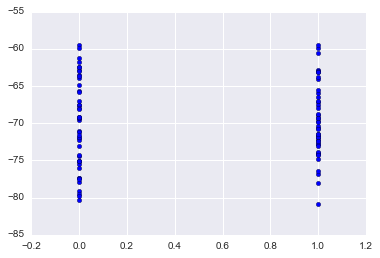

In [19]:
plt.scatter(np.zeros(len(df[df['ramps'] == 'normal']['breakin_v'])),df[df['ramps'] == 'normal']['breakin_v'])
plt.scatter(np.ones(len(df[df['ramps'] == 'pause']['breakin_v'])),df[df['ramps'] == 'pause']['breakin_v'])

In [39]:
df

,level_0,index,ACSF Date,Approach Time,BFI Witness,Bad Sweeps,Cre Status,Date,End/Abort Time,Extra Notes,...,h5_path,times,sweeps,voltages,breakin_v,ramps,wait,settle,change,abs_v
0,0,2,170130,13:29:35,NaN,NaN,human,170131,13:47:25,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 13:31:59, 2017-01-31 13:33:43, 201...","[4, 5, 6, 7]","[-78.8246078491, -78.6754989624, -78.427116394...",-79.097107,normal,104,0.272499,0.149109,0.411469
1,1,4,170130,14:01:54,NaN,NaN,human,170131,14:18:59,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 14:03:06, 2017-01-31 14:05:22, 201...","[4, 5, 6, 7]","[-73.4428024292, -73.9648971558, -73.428573608...",-74.407661,normal,136,0.964859,-0.522095,1.94979
2,2,5,170130,14:26:07,NaN,24,human,170131,14:41:55,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 14:26:18, 2017-01-31 14:28:37, 201...","[4, 5, 6, 7]","[-69.7186203003, -69.2601928711, -69.283256530...",-69.533035,normal,139,-0.185585,0.458427,0.66523
3,3,6,170130,14:47:40,NaN,NaN,human,170131,15:05:26,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 14:47:54, 2017-01-31 14:51:05, 201...","[5, 6, 7, 8]","[-73.2656402588, -72.0918579102, -70.643676757...",-73.041672,normal,191,-0.223969,1.17378,4.0603
4,4,8,170130,15:39:31,NaN,NaN,human,170131,15:56:19,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 15:41:25, 2017-01-31 15:42:45, 201...","[4, 5, 6, 7]","[-75.2652664185, -75.5804824829, -75.584892272...",-75.430534,normal,80,0.165268,-0.315216,0.478943
5,5,16,170130,13:58:13,NaN,NaN,human,170131,14:16:13,"looked like an interneuron, but ephys looks li...",...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 13:58:00, 2017-01-31 14:00:00, 201...","[4, 5, 6, 7]","[-69.467628479, -69.3736419678, -69.3279724121...",-69.299927,normal,120,-0.167702,0.0939865,0.544571
6,6,19,170130,14:58:10,NaN,NaN,human,170131,15:18:39,maybe an interneuron,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 14:59:37, 2017-01-31 15:01:27, 201...","[5, 6, 7, 8]","[-62.7750091553, -62.5059204102, -62.039665222...",-62.387924,normal,110,-0.387085,0.269089,0.85146
7,7,22,170130,16:54:54,NaN,4,human,170131,17:11:56,Pretty sure this is an interneuron woo hoo,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 16:56:17, 2017-01-31 16:58:11, 201...","[4, 5, 6, 7]","[-63.4227638245, -64.3273239136, -63.512283325...",-62.860283,normal,114,-0.562481,-0.90456,2.20223
8,8,34,170130,17:18:17,NaN,NaN,human,170131,17:36:24,Not enough time to get noise sweeps,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 17:21:17, 2017-01-31 17:21:57, 201...","[7, 8, 9, 10]","[-69.1366119385, -69.2962493896, -69.202507019...",-67.545654,normal,40,-1.59096,-0.159637,0.491325
9,9,36,170130,17:55:24,NaN,NaN,human,170131,18:14:00,NaN,...,\\titan\cns\humancelltypes\prod134\Ephys_Roi_R...,"[2017-01-31 17:57:49, 2017-01-31 17:59:30, 201...","[6, 7, 8, 9]","[-62.0235481262, -63.7515106201, -62.371429443...",-62.496223,normal,101,0.472675,-1.72796,5.10091


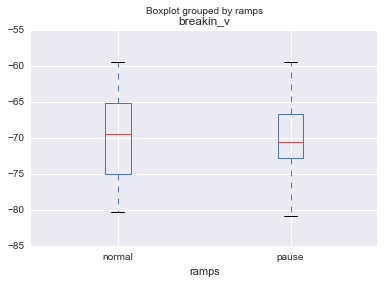

In [21]:
df.boxplot(['breakin_v'],by = 'ramps')

#df[df['ramps'] == 'pause'].boxplot(['breakin_v'])

In [22]:
df['wait'] = None
df['settle'] = None
df['change'] = None

for i in range(len(df)):
    df['wait'][i] = (df['times'][i][1]-df['times'][i][0]).seconds
    df['settle'][i] = df['voltages'][i][0] - df['breakin_v'][i]
    df['change'][i] = df['voltages'][i][1] - df['voltages'][i][0]

(-3, 3)

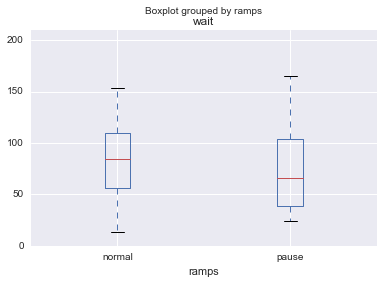

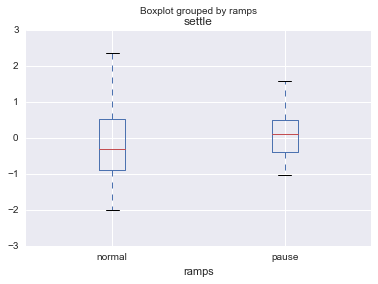

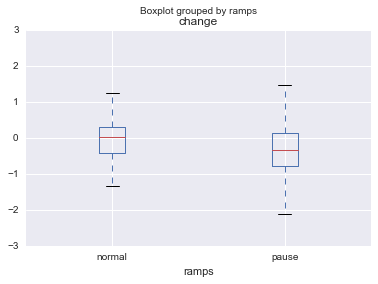

In [23]:
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()

box1 = df.boxplot(['wait'], by = 'ramps', ax=ax1)
ax1.set_ylim(0,210)

box2 = df.boxplot(['settle'], by = 'ramps', ax=ax2)
ax2.set_ylim(-3,3)

box3 = df.boxplot(['change'], by = 'ramps', ax=ax3)
ax3.set_ylim(-3,3)

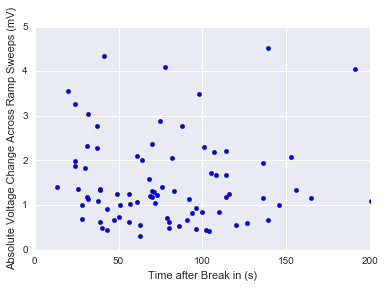

In [65]:
plt.scatter(df['wait'], df['abs_v'])
plt.ylim(0,5)
plt.xlim(0,200)
plt.xlabel('Time after Break in (s)')
plt.ylabel('Absolute Voltage Change Across Ramp Sweeps (mV)')

(-5, 5)

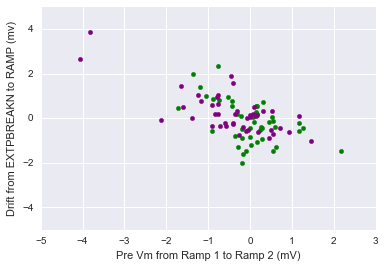

In [24]:
plt.scatter(df[df['ramps'] =='normal']['change'],df[df['ramps'] =='normal']['settle'],color = 'green')
plt.scatter(df[df['ramps'] =='pause']['change'],df[df['ramps'] =='pause']['settle'],color = 'purple')
#plt.xlim(0,600)
plt.xlabel('Pre Vm from Ramp 1 to Ramp 2 (mV)')
plt.ylabel('Drift from EXTPBREAKN to RAMP (mv)')
plt.ylim(-5,5)

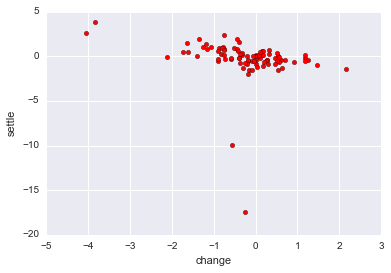

In [25]:
df.plot(kind = 'scatter',x = 'change',y = 'settle',color = 'red')

In [26]:
df['abs_v'] = None
for i in range(len(df)):
    abs_v = 0
    for j in range(1,len(df['voltages'][i])):
        abs_v += abs(df['voltages'][i][j]-df['voltages'][i][j-1])
    df['abs_v'][i] = abs_v

(0, 5)

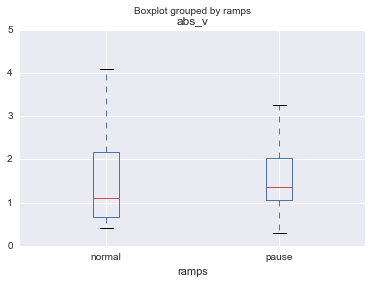

In [27]:
fig, ax = plt.subplots()
box = df.boxplot(['abs_v'], by = 'ramps', ax=ax)
ax.set_ylim(0,5)

In [532]:
#df_2016 = pd.read_csv('ephys_roi_results(2).csv')
#df_2016['voltages'] = None
#df_2016['times'] = None
#df_2016['sweeps'] = None
#df_2016['breakin_v'] = None
#df_2016['json_path'] = None
#df_2016['h5_path'] = None

for i, specimen in enumerate(df_2016['specimens'][1312:]):
    df_2016['json_path'][i] = get_json(specimen.split('-')[-1])
    df_2016['h5_path'][i] = get_h5(specimen.split('-')[-1])
    try:
        df_2016['times'][i], df_2016['sweeps'][i], df_2016['breakin_v'][i], df_2016['voltages'][i] = get_times_and_voltages(df_2016['json_path'][i], df_2016['h5_path'][i])
    except (TypeError, IndexError, AttributeError):
        pass

In [533]:
#df_2016['wait'] = None
#df_2016['settle'] = None
#df_2016['change'] = None

for i in range(len(df_2016)):
    try:
        df_2016['wait'][i] = (df_2016['times'][i][1]-df_2016['times'][i][0]).seconds
        df_2016['settle'][i] = df_2016['voltages'][i][0] - df_2016['breakin_v'][i]
        df_2016['change'][i] = df_2016['voltages'][i][1] - df_2016['voltages'][i][0]
    except TypeError:
        pass

In [377]:
df_2016['abs_v'] = None
for i in range(len(df_2016)):
    try:
        abs_v = 0
        for j in range(1,len(df_2016['voltages'][i])):
            abs_v += abs(df_2016['voltages'][i][j]-df_2016['voltages'][i][j-1])
        df_2016['abs_v'][i] = abs_v
    except TypeError:
        pass

KeyError: 'workflow_state'

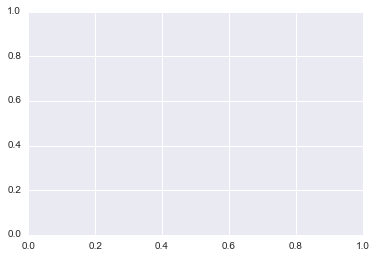

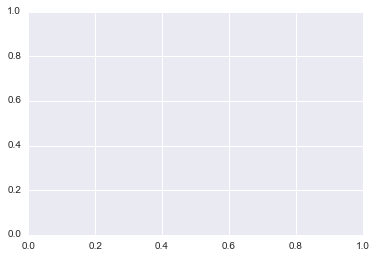

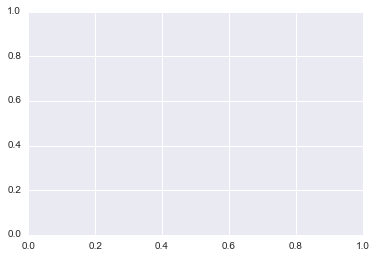

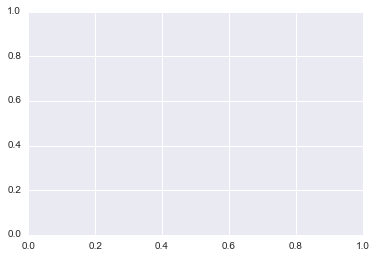

In [67]:
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
fig, ax4 = plt.subplots()

#df = df[(df['workflow_state'] == 'manual_passed') |(df['workflow_state'] == 'manual_failed')]
box1 = df.boxplot(['wait'], by = 'workflow_state', ax=ax1)
ax1.set_ylim(0,300)

box2 = df.boxplot(['settle'], by = 'workflow_state', ax=ax2)
ax2.set_ylim(-2.1,2.1)

box3 = df.boxplot(['change'], by = 'workflow_state', ax=ax3)
ax3.set_ylim(-2.5,2.5)

box4 = df.boxplot(['abs_v'], by = 'workflow_state', ax=ax4)
ax4.set_ylim(0,5)

In [542]:
df_2016.to_pickle('df_2016.pkl')

(-5, 5)

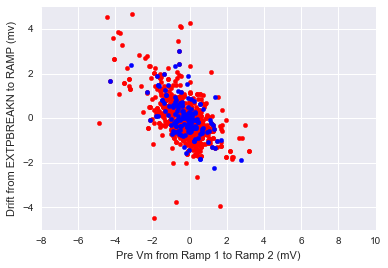

In [6]:
plt.scatter(df_2017[df_2017['workflow_state'] =='manual_passed']['change'],df_2017[df_2017['workflow_state'] =='manual_passed']['settle'],color = 'red')
plt.scatter(df_2017[df_2017['workflow_state'] =='manual_failed']['change'],df_2017[df_2017['workflow_state'] =='manual_failed']['settle'],color = 'blue')
#plt.xlim(0,600)
plt.xlabel('Pre Vm from Ramp 1 to Ramp 2 (mV)')
plt.ylabel('Drift from EXTPBREAKN to RAMP (mv)')
plt.ylim(-5,5)

In [426]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features
from collections import defaultdict


In [451]:
sweep_data = data_set.get_sweep(4)

print sweep_data['index_range']
print sweep_data['index_range'][1]/sampling_rate

sweep_data = data_set.get_sweep(5)

print sweep_data['index_range']
print sweep_data['index_range'][1]/sampling_rate

sweep_data = data_set.get_sweep(6)

print sweep_data['index_range']
print sweep_data['index_range'][1]/sampling_rate


(37500, 248984)
4.97968
(37500, 228959)
4.57918
(37500, 223942)
4.47884


(4.979, 5)

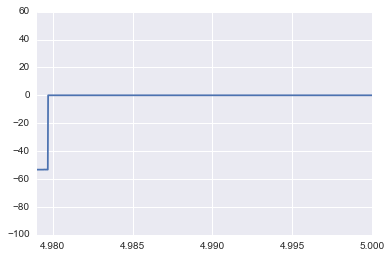

In [456]:
query2 = """
select es.sweep_number, est.description as stimulus_code, estt.name as stimulus_type from ephys_sweeps es
join ephys_stimuli est on es.ephys_stimulus_id = est.id
join ephys_stimulus_types estt on estt.id = est.ephys_stimulus_type_id
where es.specimen_id = """

file_name = '\\\\titan\\cns\\mousecelltypes\\prod593\\Ephys_Roi_Result_501951288\\501951288_ephys.nwb'
data_set = NwbDataSet(file_name)
cell = 'Rbp4-Cre_KL100;Ai14-228850.03.02.01'
sweep_data = data_set.get_sweep(4)

response = sweep_data['response']
sampling_rate = sweep_data['sampling_rate']

plt.plot(np.arange(0,len(response))/sampling_rate, response * 1000)
plt.xlim(4.979,5)

In [534]:
#df_2016['nwb_path'] = None
#df_2016['end_times'] = None
for i, cell in enumerate(df_2016['specimens']):
    try:
        df_2016['nwb_path'][i] = get_nwb(cell)
        data_set = NwbDataSet(df_2016['nwb_path'][i])
        end_times = []
        for sweep in df_2016['sweeps'][i][:3]:
            try:
                sweep_data = data_set.get_sweep(int(sweep))
                end_times.append(sweep_data['index_range'][1]/sweep_data['sampling_rate'])
            except (KeyError, AttributeError):
                pass
        df_2016['end_times'][i] = end_times
    except TypeError:
        pass

In [77]:
df_2016['avg_iti'] = None

for i in range(len(df_2016)):
    try:
        avg_iti = []
        for j, time in enumerate(df_2016['end_times'][i][:-1]):
            avg_iti.append((df_2016['times'][i][j+2] - df_2016['times'][i][j+1]).total_seconds() - time)
        df_2016['avg_iti'][i] = np.average(avg_iti)
    except TypeError:
        pass

In [82]:
for i in range(0,50):
    avg_iti = []
    for j, time in enumerate(df_2016['end_times'][i][:-1]):
        avg_iti.append((df_2016['times'][i][j+2] - df_2016['times'][i][j+1]).total_seconds() - time)
    print avg_iti



[3.1604799999999997, 1.9207000000000001]
[1.7603200000000001, 1.8808799999999994]
[438.32064000000003, 16.880320000000001]
[6.2203400000000002, -0.23934000000000033]
[86.401060000000001, 2.8808399999999992]
[12.32072, 43.300780000000003]
[0.84077999999999964, 0.98094000000000037]
[6.0612000000000004, 4.8805399999999999]
[1.3002000000000002, 2.0602999999999998]
[18.580559999999998, 4.2801]
[6.5601799999999999, 1.5005600000000001]
[4.3409200000000006, 5.1002399999999994]
[29.400939999999999, 2.0610999999999997]
[103.24034, 3.0606799999999996]
[29.06054, 4.2599400000000003]
[4.0607800000000003, 3.8005800000000001]
[3.4401399999999995, 4.8002199999999995]
[3.1412, 2.8413000000000004]
[38.36092, 8.6404200000000007]
[140.82060000000001, 1.9004999999999992]
[10.14052, 2.9007400000000008]
[3.8208200000000003, 1.6208799999999997]
[12.120699999999999, 0.88044000000000011]
[4.7402800000000003, 2.6207200000000004]
[13.0206, 3.0807200000000003]
[2.0410199999999996, 3.8608000000000002]
[3.5403400000

TypeError: 'NoneType' object has no attribute '__getitem__'

In [84]:
df_2016.iloc[2]

id                                                                        496081933
rig_name                                                                      [n/a]
notes                                                                         [n/a]
seal_gohm                                                                   1.28101
input_resistance_mohm                                                       226.047
electrode_0_pa                                                           6.51874995
failed_electrode_0                                                            False
failed_clogged_pipette                                                        [n/a]
failed_no_seal                                                                [n/a]
failed_bad_rs                                                                 False
failed_other                                                                  [n/a]
initial_access_resistance_mohm                                              

(-20, 100)

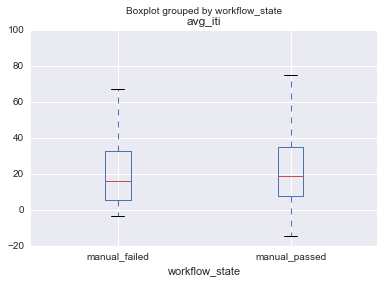

In [78]:
fig, ax1 = plt.subplots()
df_2017 = df_2016[(df_2016['workflow_state'] == 'manual_passed') |(df_2016['workflow_state'] == 'manual_failed')]
box1 = df_2017.boxplot(['avg_iti'], by = 'workflow_state', ax=ax1)
ax1.set_ylim(-20,100)


In [68]:
df_2016['avg_iti'] = None
i = 0
avg_iti = []
for j, time in enumerate(df_2016['end_times'][i][:-1]):
    avg_iti.append((df_2016['times'][i][j+1] - df_2016['times'][i][j+2]).total_seconds() + time)
df_2016['avg_iti'][i] = np.average(avg_iti)
#print avg_iti

In [69]:
print df_2016['avg_iti'][i]
print df_2016['times'][0]

-2.54059
[datetime.datetime(2016, 8, 22, 10, 2, 19), datetime.datetime(2016, 8, 22, 10, 3, 49), datetime.datetime(2016, 8, 22, 10, 3, 58), datetime.datetime(2016, 8, 22, 10, 4, 6), datetime.datetime(2016, 8, 22, 10, 4, 43)]


In [476]:
i = 10
df_2016['nwb_path'][i] = get_nwb(df_2016['specimens'][i])
data_set = NwbDataSet(df_2016['nwb_path'][i])
end_times = []
for sweep in df_2016['sweeps'][i][:3]:
    sweep_data = data_set.get_sweep(int(sweep))
    end_times.append(sweep_data['index_range'][1]/sweep_data['sampling_rate'])
df_2016['end_times'][i] = end_times

In [477]:
end_times

[0.25, 4.7591200000000002, 5.4592749999999999]

In [396]:
data['specimens'][0]['cell_ephys_features']['ramps']['spiking_sweeps'][0].keys()

[u'latency',
 u'spikes',
 u'median_isi',
 u'avg_rate',
 u'mean_isi',
 u'adapt',
 u'first_isi',
 u'id',
 u'isi_cv']

In [433]:
df_2016['json_path'][10]

u'\\\\titan\\cns\\mousecelltypes\\prod798\\Ephys_Roi_Result_527863901\\527863901_ephys_features.json'

In [480]:
df_2016['end_times']

0                                  None
1        [7.279135, 7.258945, 7.079255]
2         [5.039255, 4.85937, 5.079625]
3       [18.11888, 20.49878, 18.298365]
4         [5.01928, 5.039735, 6.119155]
5            [4.15892, 3.3592, 5.31926]
6                                  None
7                                  None
8                                  None
9                                  None
10                                 None
11                                 None
12                                 None
13                                 None
14                                 None
15                                 None
16                                 None
17                                 None
18                                 None
19                                 None
20                                 None
21                                 None
22                                 None
23                                 None
24                                 None
